![title](https://www.educafro.org.br/site/wp-content/uploads/2020/10/faculdade-insper-logo.png)

# APS Python para Ciência de Dados:

**Grupo:** Arthur Wachslicht, Gabriel Prado, Luiz Felipe Souza e Pedro Osorio Magaldi Netto

**Link .zip no Drive:** https://drive.google.com/file/d/1csJ4jFuOCSIqGVKBEhwKKgE3E4M25O_O/view?usp=sharing

## Descrição da base

A base analisada contém dados históricos referentes às taxas cobradas por diversas faculdades americanas, além de outras informações sobre as instituições, como a quantidade de alunos, a diversidade da universidade e o salário esperado dos estudantes imediatamente após a formatura.

Por meio desta análise, buscamos entender as características das faculdades que levam a um maior ou menor salário esperado após a formatura. Para tal, iniciamos nosso estudo com uma análise descritiva, buscando entender a relação entre os fatores de forma visual. Feita essa análise, partimos para o desenvolvimento de diversos modelos, focando tanto em inferência quanto em capacidade preditiva. Utilizaremos os métodos de **regressão linear**, **random forest** e **gradient boosted decision trees** para desenvolver nossa análise, separando a base em treino e teste no processo, para garantir a confiabilidade das métricas dos modelos.

### Importando as bibliotecas necessárias:

In [158]:
import pandas as pd
from siuba import *
from plotnine import *
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

theme_set(theme_bw())

### Importando os dados:

In [2]:
tuition_cost = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_cost.csv')
tuition_income = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/tuition_income.csv')
salary_potential = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/salary_potential.csv')
historical_tuition = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/historical_tuition.csv')
diversity_school = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-03-10/diversity_school.csv')

### Diversidade nas Universidades

In [4]:
diversity_percent = (diversity_school.dropna(subset=["name"]) >>
    spread(_.category, _.enrollment) >>
    transmute(_.name,
              pminority = _["Total Minority"] / _.total_enrollment,
              pforeign = _["Non-Resident Foreign"] / _.total_enrollment,
              pwomen = _["Women"] / _.total_enrollment))

### Número de estudante de cada categoria:

In [3]:
(diversity_school>>
    group_by(_.category)>>
    summarize(total_number=_.enrollment.sum()) >>
    arrange(-_.total_number))

,category,total_number
10,Women,11406332
9,White,10594649
6,Total Minority,7609693
3,Hispanic,3038062
2,Black,2623032
1,Asian,1152396
8,Unknown,1079537
5,Non-Resident Foreign,916832
7,Two Or More Races,595001
0,American Indian / Alaska Native,145875


### % médio de cada category nas universidades:

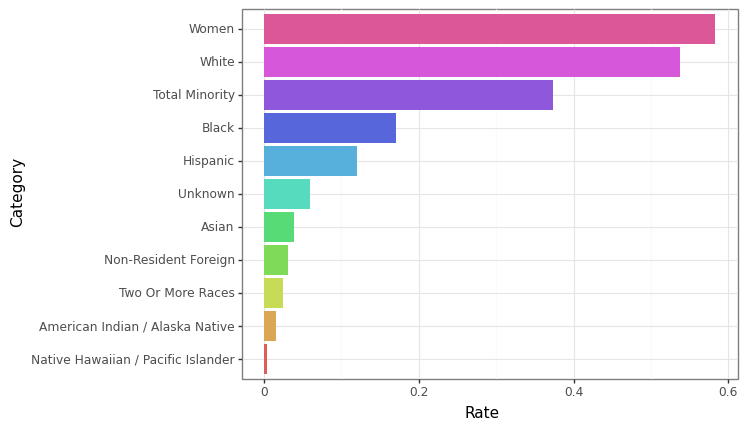

<ggplot: (181856839310)>

In [4]:
categories = (diversity_school >>
    mutate(rate=(_.enrollment/_.total_enrollment)) >>
    group_by(_.category)>>
    summarize(mean_rate=_.rate.mean()) >>
    arrange(_.mean_rate))["category"]

(diversity_school >>
    mutate(rate = (_.enrollment/_.total_enrollment),
           category = pd.Categorical(diversity_school["category"], categories = categories)) >>
    group_by(_.category) >>
    summarize(mean_rate=_.rate.mean()) >>
    ggplot(aes(x = "category", y = "mean_rate", fill = "category")) +
    geom_col(show_legend = False) +
    labs(x = "Category", y = "Rate") +
    coord_flip())

### Early Carrer Pay x Mid Carrer Pay

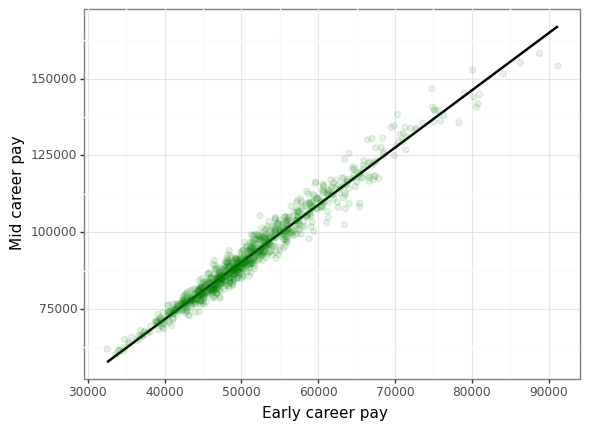

<ggplot: (181856839280)>

In [5]:
(salary_potential>>
    ggplot(aes(x="early_career_pay",y="mid_career_pay"))
    +labs(x="Early career pay",y="Mid career pay")
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .1))

### Instituições mais caras:

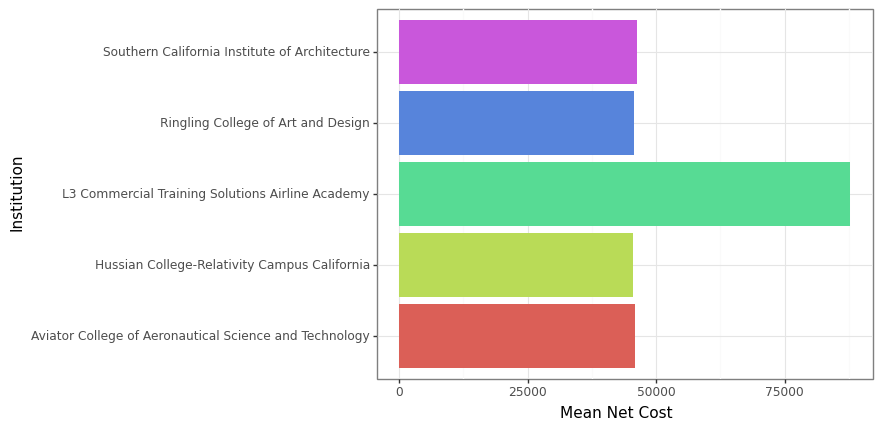

<ggplot: (181860444266)>

In [6]:
(tuition_income >> 
    group_by(_.name) >> 
    summarize(mean_net_cost=_.net_cost.mean())>>
    arrange(-_.mean_net_cost)>>
    head(5)>>
    ggplot(aes(x="name",y="mean_net_cost",fill="name"))
    +labs(x="Institution",y="Mean Net Cost",main="Most Expensive Universities")
    +geom_col(alpha=1,show_legend=False)
    +coord_flip())

### Steam Percent x Mid Carrer Pay:

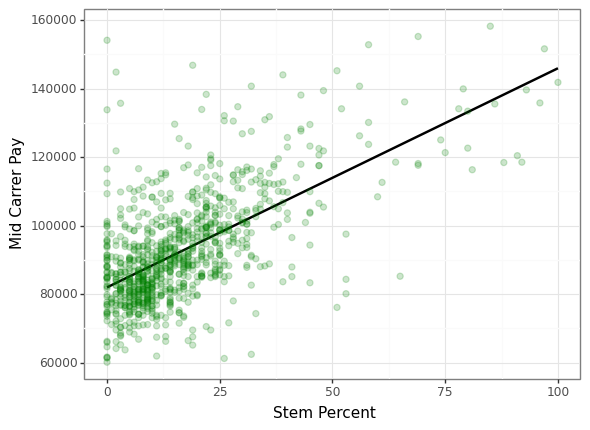

<ggplot: (181860446471)>

In [7]:
(salary_potential>>
    ggplot(aes(x="stem_percent",y="mid_career_pay"))
    +geom_smooth(color = "black", method = "lm", alpha = .5, se = False)
    +geom_point(color="green",size=2, alpha = .2)
    +labs(x="Stem Percent",y="Mid Carrer Pay"))

### Make World Better Percent x Mid Carrer Pay:

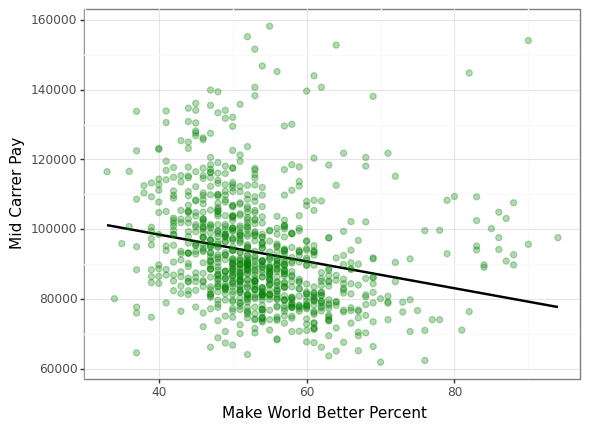

<ggplot: (181860486482)>

In [8]:
(salary_potential.dropna()>>
    ggplot(aes(x="make_world_better_percent",y="mid_career_pay"))+
    geom_smooth(color = "black", method = "lm", alpha = .5, se = False)+
    geom_point(color="green",size=2, alpha = .3)
    +labs(x="Make World Better Percent",y="Mid Carrer Pay"))

### Custo médio de tuition por nível de renda:

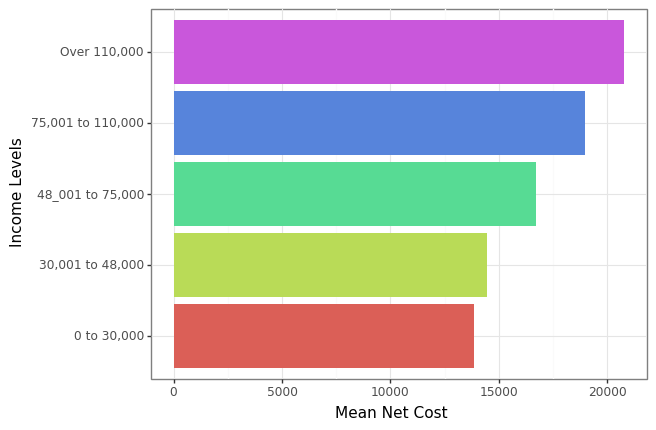

<ggplot: (181860519819)>

In [9]:
(tuition_income>>
      group_by(_.income_lvl)>>
      summarize(mean_net_cost=_.net_cost.mean())>>
      arrange(-_.mean_net_cost) >>
      ggplot(aes(x="income_lvl",y="mean_net_cost",fill="income_lvl"))+
      labs(x="Income Levels",y="Mean Net Cost",main="Mean Net Cost per Income Level")+
      geom_col(alpha=1, show_legend = False)+
      coord_flip())

### Médias salariais por estado:

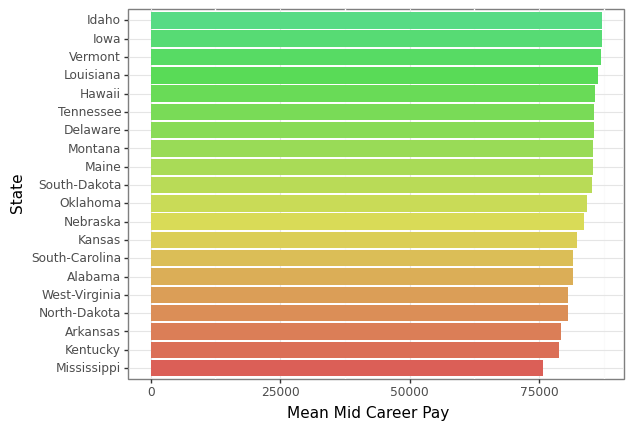

<ggplot: (181860555767)>

In [10]:
categories = (salary_potential >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    arrange(_.mean_mid_career_pay))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_mid_career_pay=_.mid_career_pay.mean()) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_mid_career_pay", fill = "state_name")) +
    geom_col(alpha=1, show_legend = False) +
    labs(x = "State", y = "Mean Mid Career Pay") +
    coord_flip())

### Média de stem percent por estado:

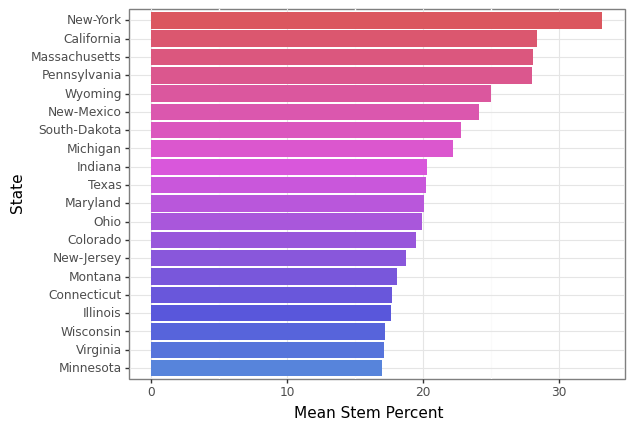

<ggplot: (181860530451)>

In [11]:
categories = (salary_potential >>
                group_by(_.state_name)>>
                summarize(mean_stem_percent=_.stem_percent.mean())>>
                arrange(_.mean_stem_percent))["state_name"]

(salary_potential >>
    mutate(state_name = pd.Categorical(salary_potential["state_name"], categories = categories)) >>
    group_by(_.state_name) >>
    summarize(mean_stem_percent=_.stem_percent.mean()) >>
    arrange(-_.mean_stem_percent) >>
    head(20) >>
    ggplot(aes(x = "state_name", y = "mean_stem_percent", fill = "state_name")) +
    geom_col(show_legend = False) +
    labs(x = "State", y = "Mean Stem Percent") +
    coord_flip())

### Custo de room and board por estado:

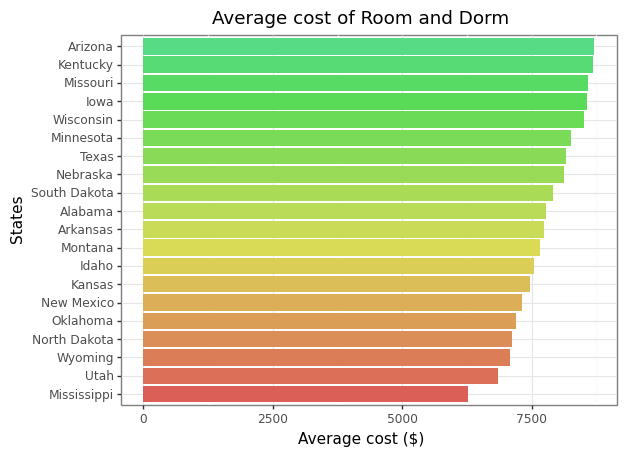

<ggplot: (181857353265)>

In [12]:
theme_set(theme_bw())

order_states = (tuition_cost >>
                group_by(_.state) >>
                summarize(avg_room_board = _.room_and_board.mean()) >>
                arrange(_.avg_room_board))["state"]

(tuition_cost >>
    mutate(state = pd.Categorical(tuition_cost["state"], categories=order_states)) >>
    group_by(_.state) >>
    summarize(avg_room_board = _.room_and_board.mean()) >>
    head(20) >>
    ggplot(aes("state", "avg_room_board")) +
    geom_col(aes(fill = "state"), show_legend = False) +
    coord_flip() +
    labs(x = "States",
         y = "Average cost ($)",
         title = "Average cost of Room and Dorm"))

### % Médio de alunos brancos nas universidades, estados com maior numero:

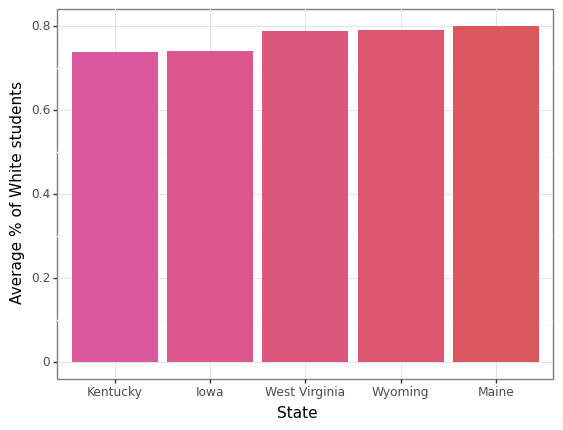

<ggplot: (181857921440)>

In [13]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate = (_.enrollment / _.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states)) >>
        group_by(_.state,_.category) >>
        summarize(mean_rate = _.rate.mean()) >>
        filter(_.category == "White") >>
        arrange(-_.mean_rate) >>
        head(5) >>
        ggplot(aes(x = "state", y = "mean_rate", fill = "state")) +
        labs(x = "State", y = "Average % of White students") +
        geom_col(alpha = 1, show_legend = False))

### % Médio de alunos brancos nas universidades, estados com menor numero:

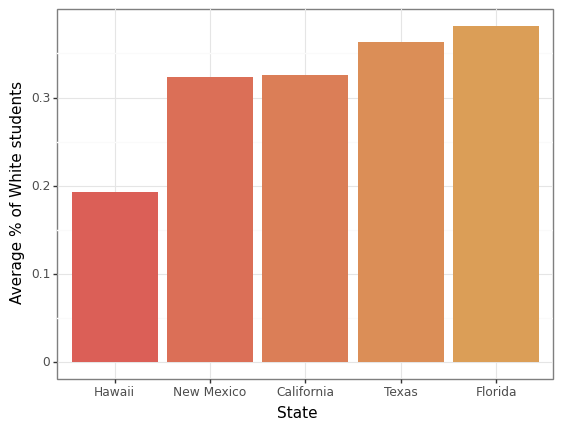

<ggplot: (181857370164)>

In [14]:
order_states = (diversity_school >>
                mutate(rate = (_.enrollment / _.total_enrollment)) >>
                group_by(_.state, _.category) >>
                summarize(mean_rate = _.rate.mean()) >>
                filter(_.category == "White") >>
                arrange(_.mean_rate))["state"]

(diversity_school>>
        mutate(rate=(_.enrollment/_.total_enrollment),
               state = pd.Categorical(diversity_school["state"], categories = order_states))>>
        group_by(_.state,_.category)>>
        summarize(mean_rate=_.rate.mean())>>
        filter(_.category=="White")>>
        arrange(_.mean_rate)>>
        head(5)>>
        ggplot(aes(x="state",y="mean_rate",fill="state"))+
        labs(x="State",y="Average % of White students")+
        geom_col(alpha=1, show_legend = False))

### Relação entre diversidade e salário inicial na carreira

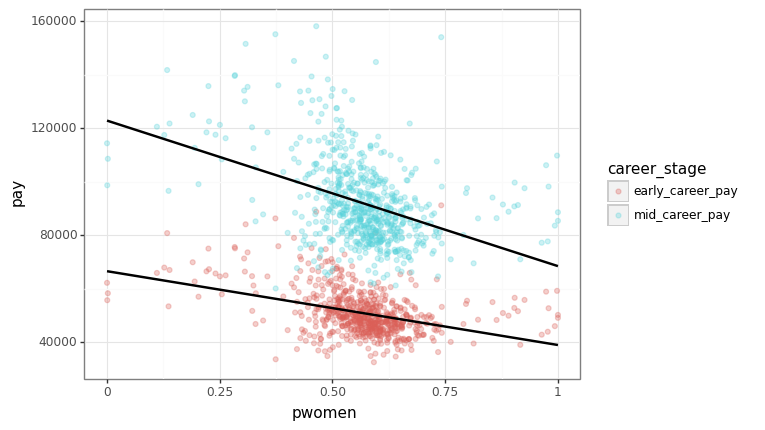

<ggplot: (162818680513)>

In [10]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pwomen", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

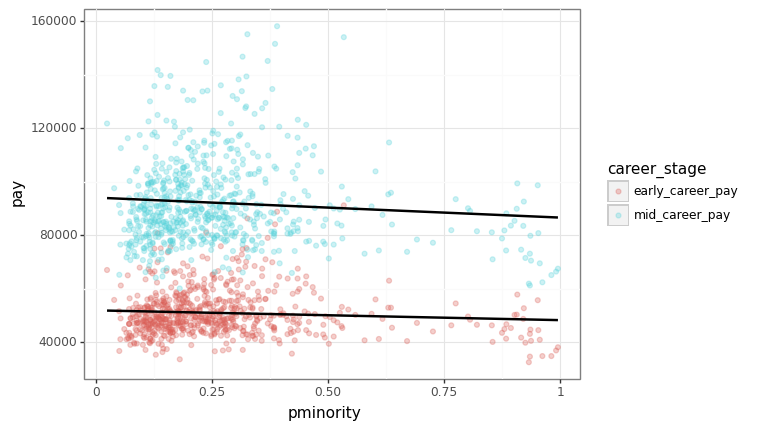

<ggplot: (162819964904)>

In [11]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pminority", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

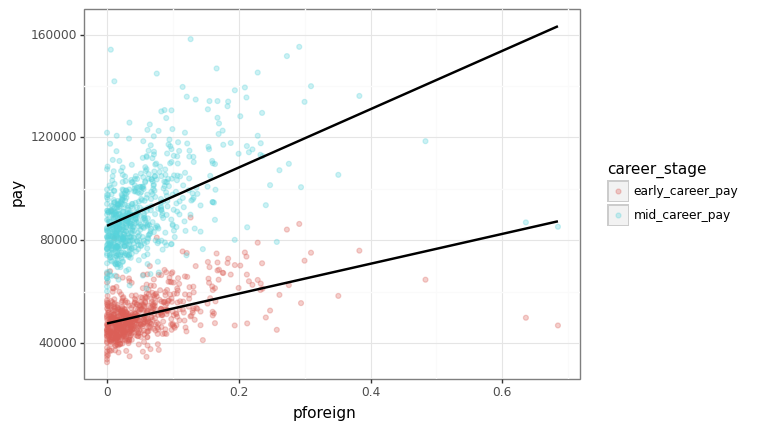

<ggplot: (162820525144)>

In [12]:
(salary_potential >>
    inner_join(_, diversity_percent, on = "name") >>
    gather("career_stage", "pay", _["early_career_pay", "mid_career_pay"]) >>
    ggplot(aes("pforeign", "pay", color = "career_stage")) +
    geom_point(alpha = .3) +
    geom_smooth(aes(group = "career_stage"), method = "lm", se = False, color = "black"))

### Regressão linear para propósitos de inferência:

$$ \large{ {Y}_{i} = \beta_{0} + \beta_{1} \ln{{X}_{1i}} + \beta_{2} {X}_{2i} + \epsilon_{i}} $$
$${}$$
$${}$$
$$ \begin{split}
{Y}_{i} &=\texttt{early_career_pay}\\
{X}_{1i} &=\texttt{make_world_better_percent}\\
{X}_{2i} &=\texttt{stem_percent} 
\end{split}$$

In [15]:
lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", salary_potential).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       early_career_pay   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.384
Method:                 Least Squares   F-statistic:                     281.7
Date:                Thu, 19 Nov 2020   Prob (F-statistic):           1.07e-95
Time:                        09:47:02   Log-Likelihood:                -9189.7
No. Observations:                 902   AIC:                         1.839e+04
Df Residuals:                     899   BIC:                         1.840e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          6.529e+04   5403.121     12.083      0.000    5.47e+04    7.59e+04
np.log(make_world_better_percent) -4868.7394   1345.611     -3.618      0.000   -7509.643   -2227.836
stem_percent                        323.9771     14.486     22.364      0.000     295.546     352.408
==============================================================================
Omnibus:                      253.318   Durbin-Watson:                   1.099
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1237.366
Skew:                           1.205   Prob(JB):                    2.04e-269
Kurtosis:                       8.207   Cond. No.                         600.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regressão linear para previsão

In [16]:
train, test = train_test_split(salary_potential.dropna(), test_size = 0.7, random_state = 1234) 

lm = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent", data = train).fit()

lm_hat = lm.predict(test)
print("RMSE:", np.sqrt(mean_squared_error(test.early_career_pay, lm_hat)).round(2), "\n")
print("R-squared:", r2_score(test.early_career_pay, lm_hat).round(4))

RMSE: 6693.72 

R-squared: 0.3411


Para realizarmos um modelo mais voltado à predição buscamos garantir que as métricas de avaliação do modelo sejam as mais confiáveis possíveis. Para isso, separamos a base de dados original em uma porção de treino e outra de teste, de forma que as métricas de qualidade dos modelos sejam coletadas em uma parcela dos dados não utilizada no treino deste. 

Utilizamos, nesta etapa, o mesmo modelo utilizado previamente - o de regressão linear - para fazer nossas previsões, método baseado na metodologia OLS para chegar a seus resultados. Obtemos um resultado razoável, com 34.11% de R-quadrado e 6693.72 de raiz do erro quadrático médio. O R-quadrado, essencialmente, indica a correlação entre os resultados previstos e os dados observados, sendo 34% um bom resultado para o modelo analisado, aparentemente. Já o RMSE mede o desvio médio entre o resultado previsto e o observado. Como o valor é de 6693.72, dado que a variância da variáveis prevista é de 15856.48, o erro parece ser razoável.

### Modelo Random Forest para previsão

In [160]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

rf = RandomForestRegressor(n_estimators=500)
rf.fit(X_trn, y_trn.ravel())

rf_hat = rf.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, rf_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, rf_hat).round(4))

RMSE: 10333.43 

R-squared: 0.5536


Buscando um melhor resultado para as previsões, rodamos também um modelo de Random Forest, um modelo baseado em árvores de decisão que consegue excelentes resultados por meio do processo de *bagging*. Apesar de um RMSE maior, o R-quadrado do método Random Forest se mostrou muito melhor do que na regressão linear. Isso pode resultar de resultados em geral mais condizentes com os valores observados, mas com erros mais significativos.

### Boosted Decision Tree para previsão

In [159]:
salary_diversity = (salary_potential >>
                    inner_join(_, diversity_percent, on = "name") >>
                    inner_join(_, tuition_cost >>
                                  select(_.name, _.type), on = "name"))

y, X = patsy.dmatrices("mid_career_pay ~ 0 + np.log(make_world_better_percent) + stem_percent + \
                        state_name + pminority + pforeign + pwomen + type", data = salary_diversity)

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.7, random_state = 1234)

boost = GradientBoostingRegressor(learning_rate = 0.01, n_estimators = 200)
boost.fit(X_trn, y_trn.ravel())

boost_hat = boost.predict(X_tst)
print("RMSE:", np.sqrt(mean_squared_error(y_tst, boost_hat)).round(2), "\n")
print("R-squared:", r2_score(y_tst, boost_hat).round(4))

RMSE: 10971.96 

R-squared: 0.4967


Como um último modelo preditivo, utilizamos a técnica de Boosting para regressão. Esse método treina, de forma sequencial, diversas árvores de regressão, utilizando o erro quadrático médio como função de perda e treinando as próximas árvores nos erros das árvores anterio

## Inferência: Tuition vs Mid career pay

In [140]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("mid_career_pay ~ np.log(make_world_better_percent) + stem_percent + net_cost + type", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         mid_career_pay   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                 1.422e+04
Date:                Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                        18:01:20   Log-Likelihood:            -5.6592e+05
No. Observations:               53053   AIC:                         1.132e+06
Df Residuals:                   53048   BIC:                         1.132e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           1.77e+05   1262.607    140.158      0.000    1.74e+05    1.79e+05
type[T.Public]                    -2908.2989    107.598    -27.029      0.000   -3119.191   -2697.407
np.log(make_world_better_percent)  -2.49e+04    305.936    -81.398      0.000   -2.55e+04   -2.43e+04
stem_percent                        589.6350      3.072    191.943      0.000     583.614     595.656
net_cost                              0.2424      0.007     36.392      0.000       0.229       0.255
==============================================================================
Omnibus:                    11429.916   Durbin-Watson:                   0.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            49784.277
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       7.304   Cond. No.                     6.13e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Inferência: Make World Better vs Tuition

In [148]:
tuition_salary = (tuition_income >>
                  inner_join(_, salary_potential, on = "name") >>
                  inner_join(_, tuition_cost >>
                                    transmute(_.name, _.type,
                                    public = _.type == "Public",
                                    private = _.type == "Private",
                                    boolean = _.public | _.private) >>
                                    filter(_.boolean) >>
                                    select(_["name", "type"]), on = "name"))

lin_reg = smf.ols("np.log(make_world_better_percent) ~ net_cost + type + stem_percent", tuition_salary).fit()
lin_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     np.log(make_world_better_percent)   R-squared:                       0.070
Model:                                           OLS   Adj. R-squared:                  0.070
Method:                                Least Squares   F-statistic:                     1330.
Date:                               Sat, 28 Nov 2020   Prob (F-statistic):               0.00
Time:                                       18:03:28   Log-Likelihood:                 26306.
No. Observations:                              53053   AIC:                        -5.260e+04
Df Residuals:                                  53049   BIC:                        -5.257e+04
Df Model:                                          3                                         
Covariance Type:                           nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          4.0910      0.002   1732.219      0.000       4.086       4.096
type[T.Public]    -0.0252      0.002    -16.538      0.000      -0.028      -0.022
net_cost         -4.7e-06   9.23e-08    -50.915      0.000   -4.88e-06   -4.52e-06
stem_percent      -0.0014   4.32e-05    -33.156      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      484.676   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              627.579
Skew:                           0.146   Prob(JB):                    5.28e-137
Kurtosis:                       3.445   Cond. No.                     8.66e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.66e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Criando variáveis potencialmente úteis para a modelagem

In [21]:
tuition_cost_peruni = (tuition_cost >>
     group_by(_.name) >>
     summarize(state = _.state.head(1),
               state_code = _.state_code.head(1), 
               avg_in_state = _.in_state_total.mean(skipna = True),
               avg_out_state = _.out_of_state_total.mean(skipna = True),
               avg_room_board = _.room_and_board.mean(skipna = True)) >>
     mutate(avg_in_state = _.avg_in_state.fillna(0),
            avg_out_state = _.avg_out_state.fillna(0),
            avg_room_board = _.avg_room_board.fillna(0)) >>
     transmute(university = _.name,
               state = _.state,
               state_code = _.state_code,
               avg_tuition_cost = _.avg_room_board + (_.avg_in_state + _.avg_out_state).mean(skipna = True)))

# Perguntas:

### Seria Mid Career Pay a variável resposta mais relevante para nós?
### Quais seriam as variáveis explicativas mais relevantes?
### Será que a Tuition pode ser explicada pelo Mid Career Pay e Early Career Pay, com maior demanda para faculdades mais "bem sucedidas e assim aumentando o seu preço?